# KU-HAR dataset  

dataset  
https://data.mendeley.com/datasets/45f952y38r/3

18 activities collected from 90 participants  
using smartphone sensors (Accelerometer and Gyroscope)  
sampling rate : 100Hz

In [1]:
import os
import pickle
import glob
from sklearn import preprocessing
from sklearn.metrics import f1_score
import pandas as pd
import itertools
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-amfi8tda because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import socket
hostname = socket.gethostname()
print(hostname)

f1b2c6893cf4


In [3]:
def convert_to_one_hot(class_number, total_classes):
    one_hot = np.zeros(total_classes)
    one_hot[class_number] = 1
    return one_hot

In [4]:
dirout = 'out'
if not os.path.exists(dirout):
    os.makedirs(dirout)

## Data load

In [5]:
data_loc = '../Dataset/04_KU-HAR_Dataset'

In [6]:
class_name = ["standing","sitting", "lying", "walking", "running", "upstairs", "downstairs"]
csv_label = ["0.Stand","1.Sit","5.Lay","11.Walk","14.Run","15.Stair-up","16.Stair-down"]
feature_name = ['acc_x', 'acc_y', 'acc_z',  'ang_x', 'ang_y', 'ang_z']
num_data_cols = len(feature_name)
nsample_crop = 200   # sampling rate가 100Hz 이므로 2초 단위로 segment
n_classes = len(class_name)

In [7]:
vdatac = [[] for i in range(n_classes)]
vlabelc =[[] for i in range(n_classes)] 
vttc =  [[] for i in range(n_classes)] 

for i in range(len(csv_label)):
    fname = sorted(glob.glob('{}/{}/*.csv'.format(data_loc, csv_label[i])))
    for j in range(len(fname)):
        raw_data = pd.read_csv(fname[i], header=None)
        raw_data = raw_data[[0,1,2,3,5,6,7]]
        fdata = raw_data.to_numpy()
        window_num = len(raw_data)//nsample_crop
        for k in range(window_num):  
            start = nsample_crop * k
            end = nsample_crop * (k+1)
            #print(k, start, end)
            vdata_temp = fdata[start:end, 1:]
            vlabel_temp = i
            vtt_temp = fdata[start:end, :1]
            vdatac[i].append(vdata_temp)
            vlabelc[i].append(convert_to_one_hot(vlabel_temp, n_classes))
            vttc[i].append(vtt_temp)

In [8]:
for i in range(n_classes):
    temp = np.shape(vdatac[i])[0]
    print(i, class_name[i],'-->', round(temp*nsample_crop*10/1000/60, 1), 'min / ', round(temp*nsample_crop*10/1000/60/60, 2), 'hrs')

0 standing --> 100.9 min /  1.68 hrs
1 sitting --> 90.9 min /  1.52 hrs
2 lying --> 87.8 min /  1.46 hrs
3 walking --> 50.1 min /  0.84 hrs
4 running --> 24.3 min /  0.41 hrs
5 upstairs --> 40.6 min /  0.68 hrs
6 downstairs --> 41.8 min /  0.7 hrs


In [9]:
for i in range(n_classes):
    tt =vttc[i]
    print(i,'\t', np.shape(vdatac[i]),'\t', np.shape(vlabelc[i]), '\t', class_name[i])

0 	 (3026, 200, 6) 	 (3026, 7) 	 standing
1 	 (2728, 200, 6) 	 (2728, 7) 	 sitting
2 	 (2635, 200, 6) 	 (2635, 7) 	 lying
3 	 (1504, 200, 6) 	 (1504, 7) 	 walking
4 	 (730, 200, 6) 	 (730, 7) 	 running
5 	 (1219, 200, 6) 	 (1219, 7) 	 upstairs
6 	 (1254, 200, 6) 	 (1254, 7) 	 downstairs


## downsampling

In [10]:
downsampling = True

In [11]:
if downsampling:
    if nsample_crop == 200:  #100Hz
        newnsample_crop = 100  #50Hz

(200, 6) --> (100, 6)


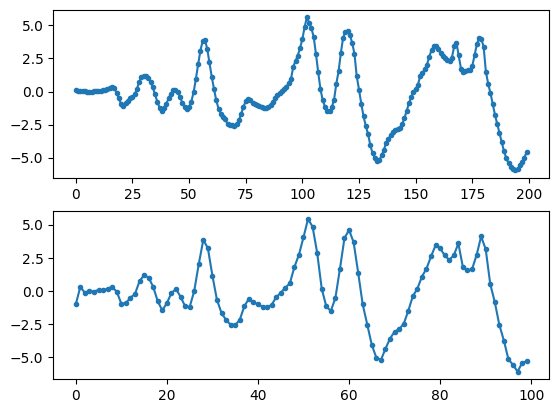

In [12]:
# 하나만 테스트
if downsampling:
    original = vdatac[3][0]
    resampling = signal.resample(vdatac[3][0], newnsample_crop)
    print(np.shape(original), '-->', np.shape(resampling))

    plt.subplot(2,1,1)
    plt.plot(np.transpose(original)[0], '.-')
    plt.subplot(2,1,2)
    plt.plot(np.transpose(resampling)[0], '.-')
    plt.show()

In [13]:
rvdatac = [[] for i in range(n_classes)]

if downsampling:
    for i in range(n_classes):
        for j in range(len(vdatac[i])):
            resampling = signal.resample(vdatac[i][j], newnsample_crop)
            rvdatac[i].append(resampling)
        rvdatac[i] = np.array(rvdatac[i])
        print(np.shape(rvdatac[i]))

(3026, 100, 6)
(2728, 100, 6)
(2635, 100, 6)
(1504, 100, 6)
(730, 100, 6)
(1219, 100, 6)
(1254, 100, 6)


In [14]:
if downsampling:
    vdatac = rvdatac
    downTF = 'DS'
    nsample_crop = newnsample_crop 
else:
    downTF = 'OS'

In [15]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_time_series_data(datas):
    length = np.shape(datas[0])[1]
    dim = np.shape(datas[0])[2]
    # Combine all the data
    all_data = np.concatenate(datas, axis=0)
    all_data = all_data.reshape(-1, dim)
    
    # Initialize a StandardScaler
    scaler = StandardScaler()
    
    # Fit the scaler to the data and scale it
    all_data = scaler.fit_transform(all_data)

    # Initialize an empty list to store the start indices of each class
    start_indices = [0]

    # Calculate the start index of each class
    for data in datas:
        start_indices.append(start_indices[-1] + len(data))

    all_data = all_data.reshape(-1, length, dim)
    # Split the combined data into the original classes
    scaled_datas = [all_data[start_indices[i]:start_indices[i+1]] for i in range(len(start_indices)-1)]

    return scaled_datas, scaler

In [16]:
# 데이터 정규화
datac_all_norm, scaler = scale_time_series_data(vdatac)

In [17]:
np.shape(vdatac[0]), np.shape(datac_all_norm[0])

((3026, 100, 6), (3026, 100, 6))

In [18]:
# # 정규화 적용 확인코드
# idx = 500
# cls = 3
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(vdatac[cls][idx])
# plt.subplot(1,2,2)
# plt.plot(datac_all_norm[cls][idx])
# plt.show()

In [19]:
print('Shuffled data...')
for i in range(n_classes):
    np.random.shuffle(datac_all_norm[i])

Shuffled data...


In [20]:
from sklearn.model_selection import train_test_split

def split_data_and_labels(datas, labels, test_size=0.2):
    data_train = []
    data_test = []
    labels_train = []
    labels_test = []

    for data, label in zip(datas, labels):
        data_tr, data_te, label_tr, label_te = train_test_split(data, label, test_size=test_size, random_state=42)
        data_train.append(data_tr)
        data_test.append(data_te)
        labels_train.append(label_tr)
        labels_test.append(label_te)

    return data_train, data_test, labels_train, labels_test

In [21]:
data_train, data_test, labels_train, labels_test = split_data_and_labels(datac_all_norm, vlabelc)

In [22]:
sz_train = []
sz_test = []

for i in range(n_classes):
    print(np.shape(data_train[i]), np.shape(data_test[i]))
    sz_train.append(len(data_train[i]))
    sz_test.append(len(data_test[i]))
    if i == 0:
        trainX = data_train[i]
        trainy = labels_train[i]
        
        testX = data_test[i]
        testy = labels_test[i]
    else:
        trainX   = np.vstack((trainX, data_train[i]))
        trainy = np.vstack((trainy, labels_train[i]))
        
        testX   = np.vstack((testX, data_test[i]))
        testy = np.vstack((testy, labels_test[i]))

(2420, 100, 6) (606, 100, 6)
(2182, 100, 6) (546, 100, 6)
(2108, 100, 6) (527, 100, 6)
(1203, 100, 6) (301, 100, 6)
(584, 100, 6) (146, 100, 6)
(975, 100, 6) (244, 100, 6)
(1003, 100, 6) (251, 100, 6)


In [23]:
print(np.shape(trainX))
print(np.shape(trainy))
print(np.shape(testX))
print(np.shape(testy))

(10475, 100, 6)
(10475, 7)
(2621, 100, 6)
(2621, 7)


In [24]:
loadFromPickle = False #True #False

In [25]:
outdir_pickle = './pickle/KU-HAR'
dname = 'KU-HAR'
fn_pickle_pub = '{}/KU-HAR_{}_class{}_len{}_pub_23.pickle'.format(outdir_pickle, downTF, n_classes, nsample_crop)
print(fn_pickle_pub)

if not os.path.exists(outdir_pickle):
    os.mkdir(outdir_pickle)


if loadFromPickle:
    if os.path.exists(fn_pickle_pub):
        print('{} exists....'.format(fn_pickle_pub))
    else:
        print('{} does NOT exists....'.format(fn_pickle_pub))
        loadFromPickle = False
        print('loadFromPickle....{}'.format(loadFromPickle))  

if not loadFromPickle:
    datasave = [None] * 9
    datasave[0] = trainX
    datasave[1] = trainy
    datasave[2] = testX
    datasave[3] = testy
    datasave[4] = class_name
    datasave[5] = feature_name
    datasave[6] = scaler
    datasave[7] = sz_train
    datasave[8] = sz_test

    file = open(fn_pickle_pub, 'wb')
    pickle.dump(datasave, file)
    file.close()

    print('-------------------------------------------')
    print('# Saved files for publication\n ---> \n{}'.format(fn_pickle_pub)) 
    print('-------------------------------------------')

else:
    print('load from pickle files')
    file = open(fn_pickle_pub, 'rb')
    data = pickle.load(file)
    file.close()
    
    trainX = data[0]
    trainy = data[1]  
    testX = data[2]  
    testy = data[3] 
    class_name_pub = data[4] 
    feature_name = data[5]
    scaler = data[6]
    sz_train = data[7]
    sz_test = data[8]

../pickle/KU-HAR/KU-HAR_DS_class7_len100_pub_23.pickle
-------------------------------------------
# Saved files for publication
 ---> 
../pickle/KU-HAR/KU-HAR_DS_class7_len100_pub_23.pickle
-------------------------------------------


In [26]:
# # 데이터 시각화
# f, ax = plt.subplots(n_classes, 1, figsize=(8,8), squeeze=False, sharex=True)
# for i in range(n_classes):
#     ax[i//1, i%1].plot(data_train[i][200])
#     ax[i//1, i%1].set_title('{}'.format(class_name[i]))
# plt.tight_layout(pad=0.3)
# plt.show()